<a href="https://colab.research.google.com/github/44787313/prog2024/blob/main/Homework_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Flocking Homework

Biology 1134

10/9/25

Due: Friday 10/17/25 by 5pm

# Problem 1: Orthogonal leaders

Modify the simulation code you developed in the lab to have a subset of 10 informed leaders that move in orthogonal directions (e.g. $\pi/2$ vs. $0$). Using the same parameters as in the lab, evaluate whether or not one "wins" or if both groups "win" (i.e. distinct patches of individuals move in the direction of the two different groups). Watch videos and plot time courses to assess.

In [2]:
def informed_boids_dyn(pars):
  thetam = pars['thetam']
  m=pars['m']
  N=pars['N']
  eta=pars['eta']
  L=pars['L']
  totsteps=pars['totsteps']
  delt=pars['dt']
  v0=pars['v0']
  r=pars['r']
  # Initialize
  currx=np.random.uniform(size=N)*L
  curry=np.random.uniform(size=N)*L
  currtheta = np.random.uniform(size=N)*2*np.pi

  # Preallocate output
  xt = np.zeros((totsteps,N))
  yt = np.zeros((totsteps,N))
  thetat = np.zeros((totsteps,N))

  # Simulation
  for t in range(totsteps):
    newtheta = np.zeros(N)
    # Orthogonal leaders
    newtheta[:int(m/2)]= thetam
    newtheta[int(m/2+1):m]= thetam - (np.pi)/2
    # Loop through each boid and estimate new directions
    for i in range(m+1, N):
      dx = np.minimum(np.abs(currx-currx[i]),
                      np.abs(currx-currx[i]+L),
                      np.abs(currx-currx[i]-L))
      dy = np.minimum(np.abs(curry-curry[i]),
                      np.abs(curry-curry[i]+L),
                      np.abs(curry-curry[i]-L))

      boid_r = np.sqrt(dx**2 + dy**2)
      thetas = currtheta[boid_r <= r]
      avgx = np.mean(np.cos(thetas))
      avgy = np.mean(np.sin(thetas))
      newtheta[i]=np.arctan2(avgy,avgx)

    # Obtain noise vector(from -eta/2 to eta/2)
    deltheta = -eta/2 + eta*np.random.uniform(size=N)
    # Add noise
    currtheta = newtheta+deltheta

    currx = np.mod(currx + v0*np.cos(currtheta*delt), L)
    curry = np.mod(curry + v0*np.sin(currtheta*delt), L)
    xt[t,:] = currx
    yt[t,:] = curry
    thetat[t,:] = currtheta
  return xt,yt,thetat

In [3]:
pars = {}
pars['m']=10
pars['thetam']=np.pi / 2
pars['N'] = 250
pars['L'] = 5
pars['totsteps'] = 901
pars['dt'] = 0.2
pars['v0'] = 0.03
pars['r'] = 0.5
pars['eta'] = 0.1

xt, yt, thetat = informed_boids_dyn(pars)

In [ ]:
def movie_dyn(xt, yt, thetat, pars, filename='boids_movie.mp4'):
  fig, ax = plt.subplots(figsize=(5,5))
  N = pars['N']
  L = pars['L']
  ax.set_xlim(0,L)
  ax.set_ylim(0,L)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_aspect('equal')
  # Initialize with first frame's data
  sc = ax.plot(xt[0,:], yt[0,:], 'k.')[0]
  qv = ax.quiver(xt[0,:], yt[0,:], np.cos(thetat[0,:]), np.sin(thetat[0,:]), color='grey', scale=15, width=0.006)

  def update(i):
    sc.set_data(xt[i,:], yt[i,:])
    qv.set_offsets(np.c_[xt[i,:], yt[i,:]])
    qv.set_UVC(np.cos(thetat[i,:]), np.sin(thetat[i,:]))
    ax.set_title(f't = {i}')
    return sc,qv

  anim = animation.FuncAnimation(fig, update, frames=len(xt), blit=True)
  anim.save(filename, writer='ffmpeg', fps=30, dpi=200)
  plt.close(fig)
  print(f'Animation saved as {filename}')

In [ ]:
movie_dyn(xt, yt, thetat, pars)

Animation saved as boids_movie.mp4


In [ ]:
from google.colab import files
files.download('boids_movie.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
# Order parameter
def dyn2orderpar(thetat):
  #Calculate avg. velocity
  N = len(thetat[0,:])
  vxt = np.array([np.cos(thetat[i]) for i in range(N)])
  vyt = np.array([np.sin(thetat[i]) for i in range(N)])
  sumvxt = np.sum(vxt,1)
  sumvyt = np.sum(vyt,1)
  normvt = np.sqrt(sumvxt**2 + sumvyt**2) / N
  return(normvt)

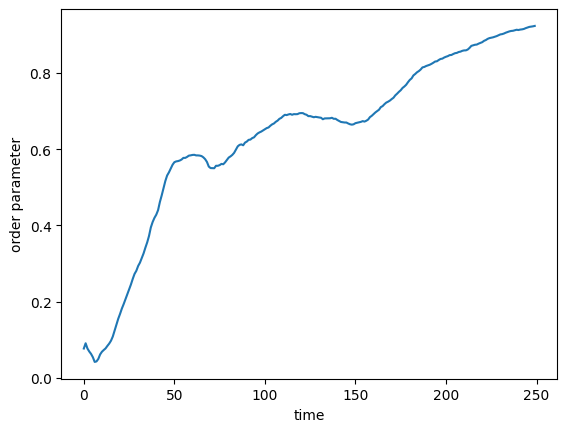

In [5]:
plt.plot(dyn2orderpar(thetat))
plt.xlabel('time')
plt.ylabel('order parameter')
plt.show()

It seems that neither of the group wins. Instead, the population finally moves in the direction of the average of the two groups.

# Problem 2: Critical Noise

Measure the order parameter as a function of noise using a flock size of $N=300$, $r=0.3$, $v_o = 0.03$, $dt=0.2$, and $totsteps=901$. Modulate $\eta$ from 0 to 4 in increments of 0.25, using `eta_range = np.arange(0,4.1,0.25)`. Identify a transition point between order and disorder.

To do this, first plot the order parameter over time for all noise values.

Then, average the last 400 timepoints of the order parameter for each value of $\eta$. (You could do this with a loop containing a line of code such as: `np.mean(dyn2orderpar(thetat_dict[this_eta])[-400:])`, assuming you have a dictionary `thetat_dict` which has your `thetat` outputs from looping over `eta_range`.) Make a scatter plot of those averages on the y axis vs. noise on the x axis.

Finally, choose a critical value of noise that marks your transition point. Produce a plot like the one in Fig. 3 of the Vicsek et al. paper by plotting the averaged order parameters from above vs. $(\eta_c - \eta)/\eta_c$. How does your plot compare to the one in the paper? You can try adding more noise values if you'd like to make it more similar.

In [6]:
pars['N']=300
pars['r']=0.3
pars['v0']=0.03
pars['dt']=0.2
pars['totsteps']=901
eta_range = np.arange(0,4.1,0.25)

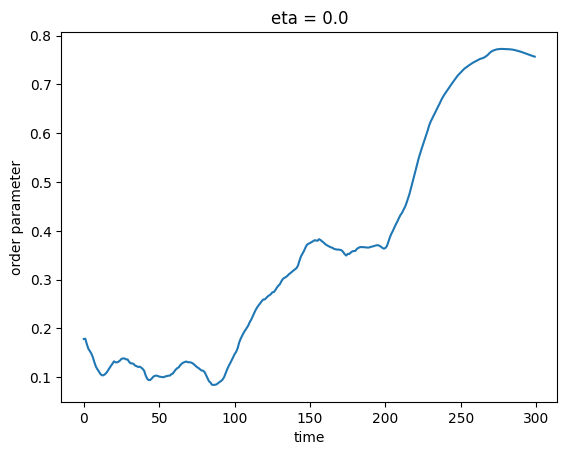

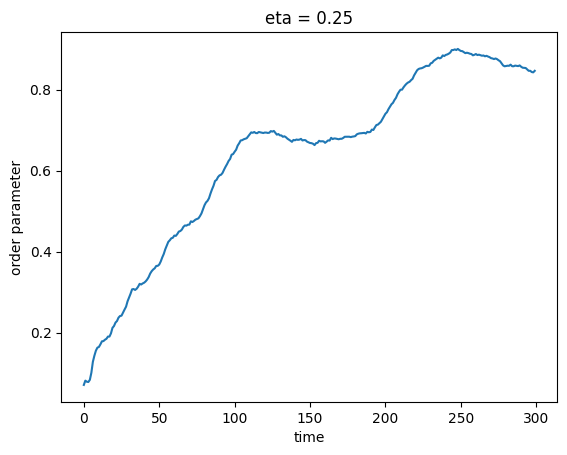

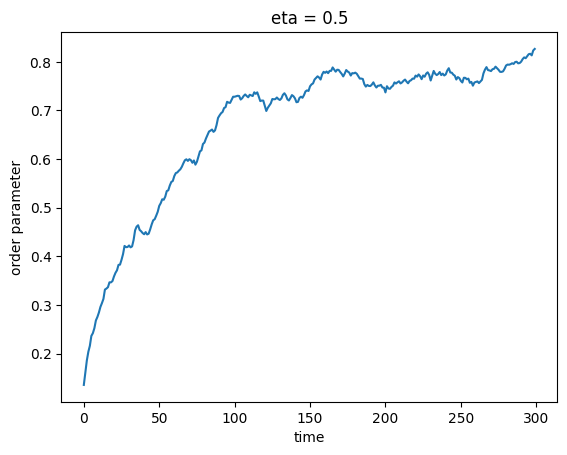

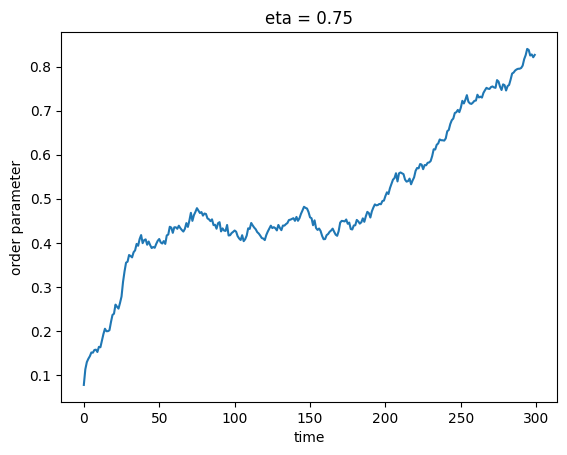

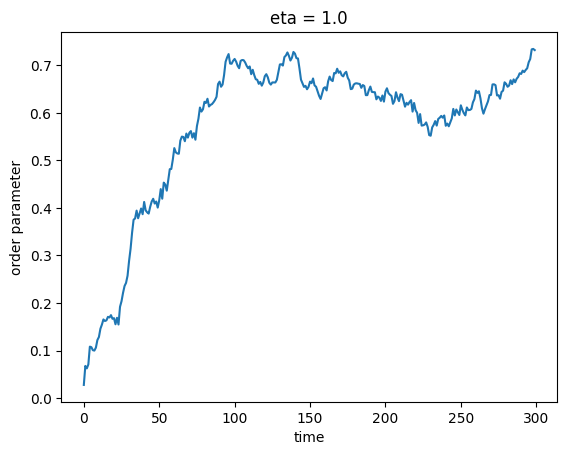

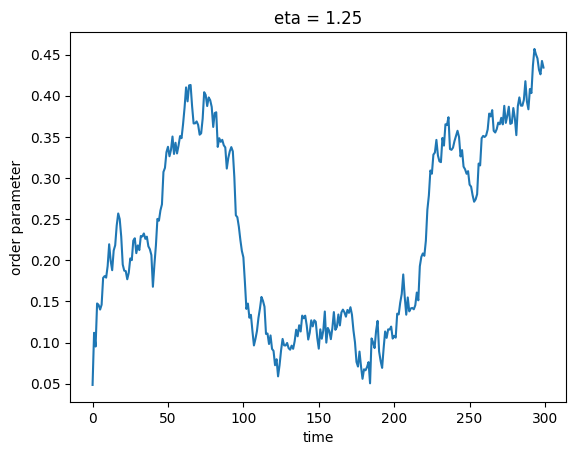

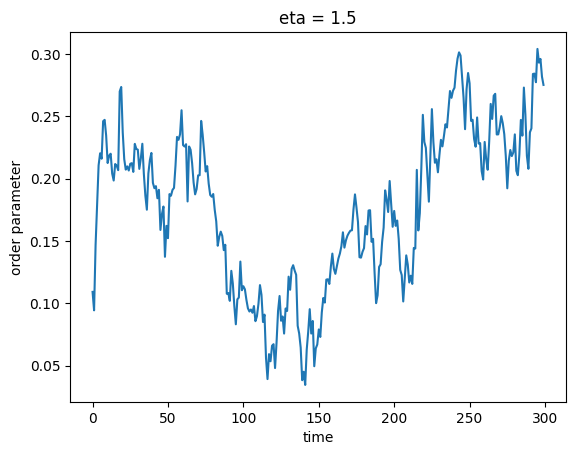

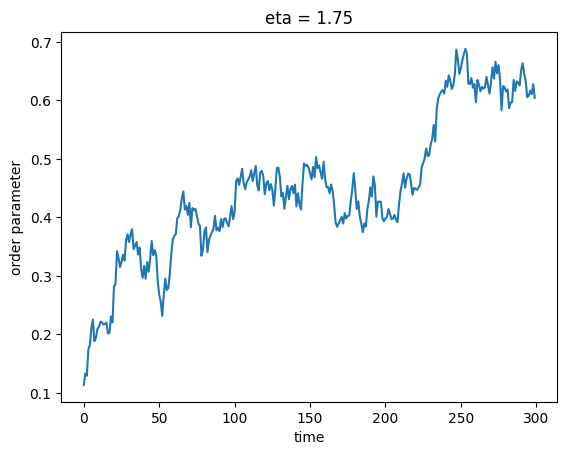

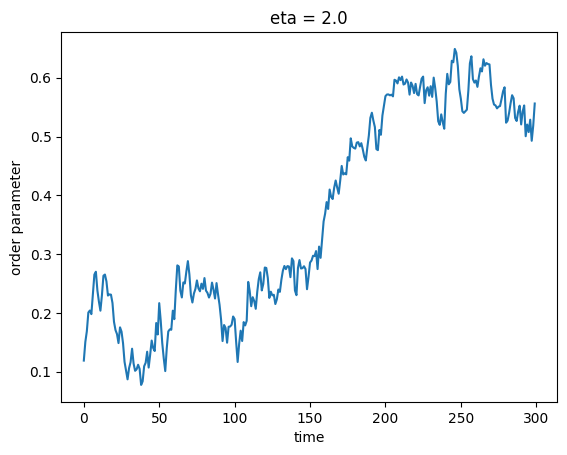

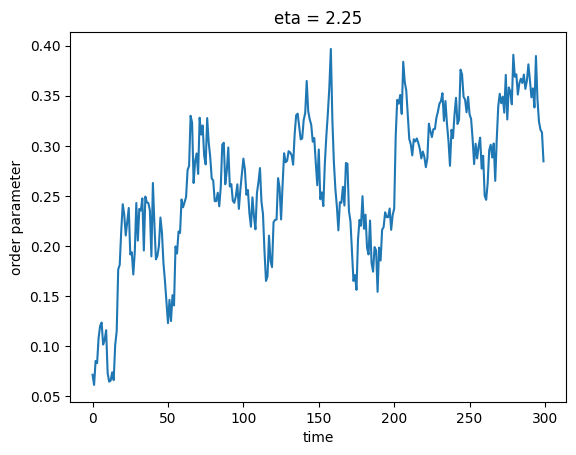

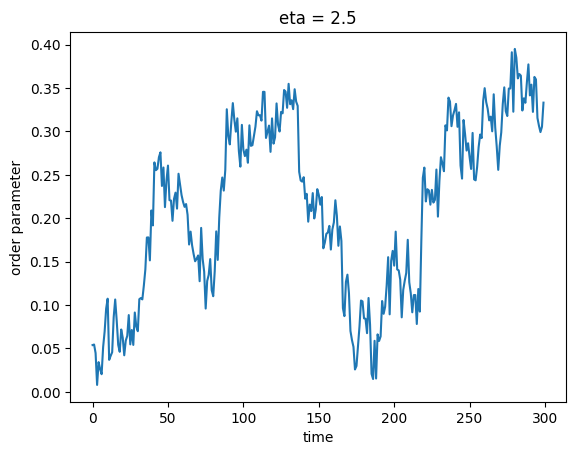

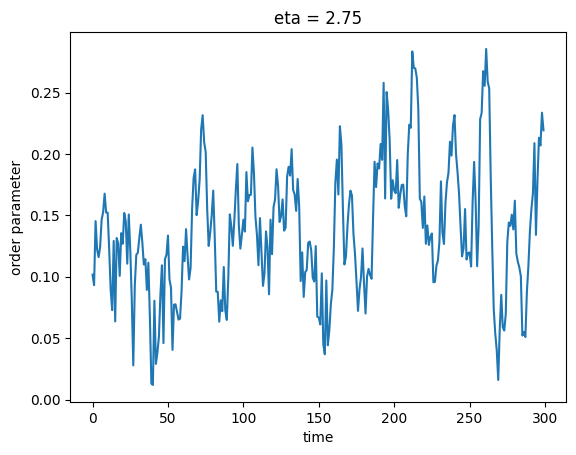

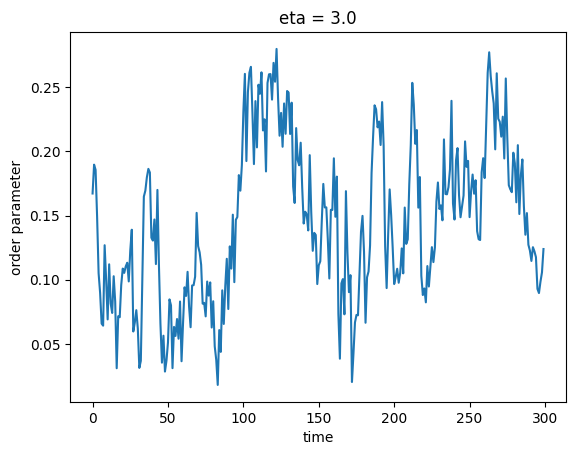

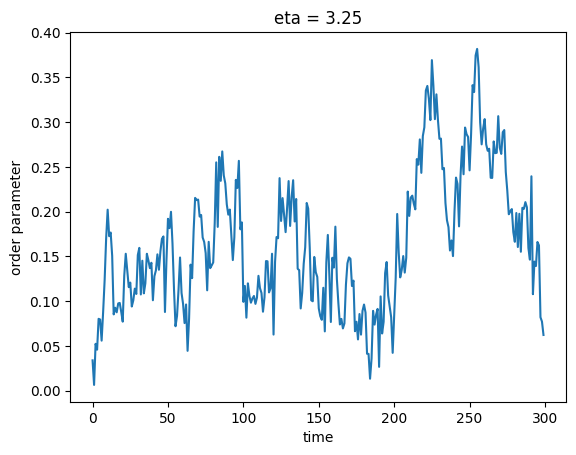

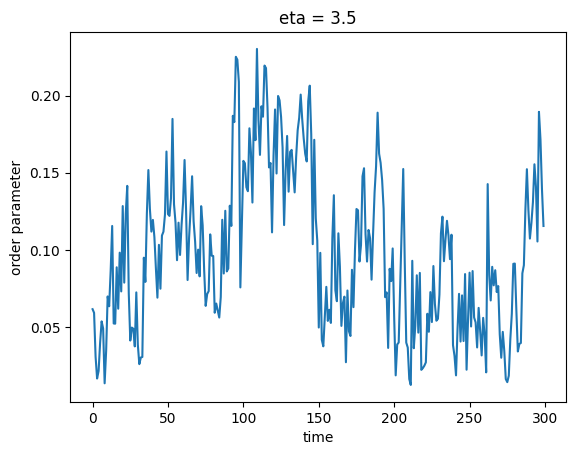

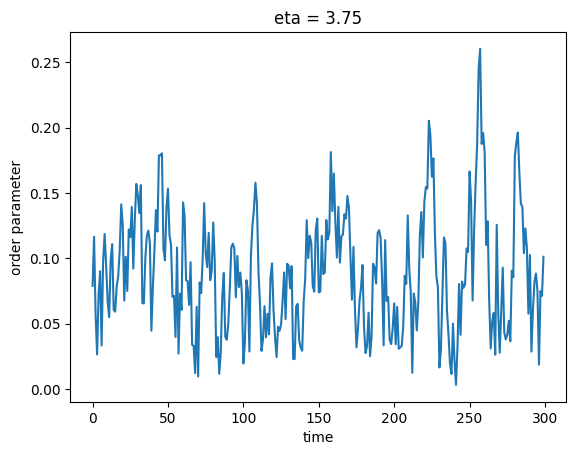

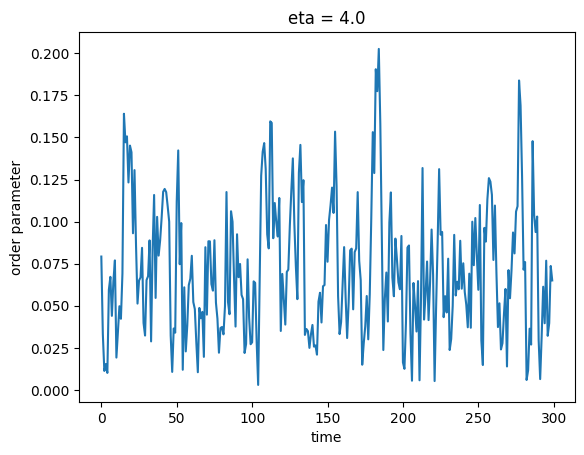

In [7]:
theta_dict = {}
for eta in eta_range:
  pars['eta'] = eta
  xt, yt, thetat = informed_boids_dyn(pars)
  theta_dict[eta] = thetat
  plt.plot(dyn2orderpar(thetat))
  plt.title(f'eta = {eta}')
  plt.xlabel('time')
  plt.ylabel('order parameter')
  plt.show()


Transition point: eta=2.0

In [8]:
mean400 = []
for this_eta in eta_range:
  x = this_eta
  y = np.mean(dyn2orderpar(theta_dict[this_eta])[-400:])
  mean400.append([x,y])

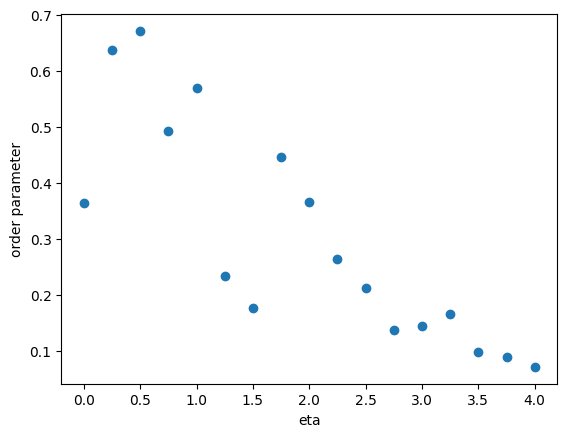

In [9]:
plt.scatter(np.array(mean400)[:,0], np.array(mean400)[:,1])
plt.xlabel('eta')
plt.ylabel('order parameter')
plt.show()

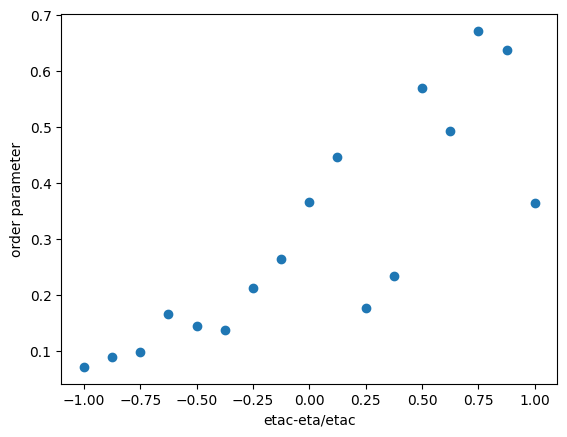

In [11]:
etac = 2.0
critical = []
for eta in eta_range:
  critical.append((etac-eta)/etac)
plt.scatter(critical, np.array(mean400)[:,1], )
plt.plot
plt.ylabel('order parameter')
plt.xlabel('etac-eta/etac')
plt.show()

My plot is similar to the paper's plot in overall trend.